# Advanced Lane Lines Finding

In [17]:
import os
import sys

import numpy as np
import cv2
import glob
from sklearn import linear_model
from moviepy.editor import VideoFileClip
from collections import deque

In [15]:
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
%matplotlib inline

## 1. Remove distortion

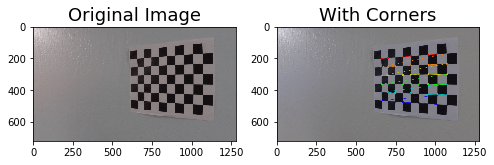

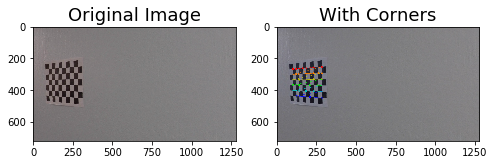

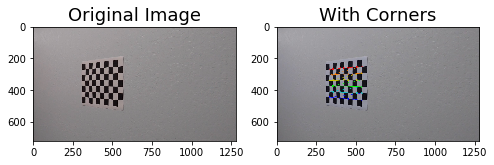

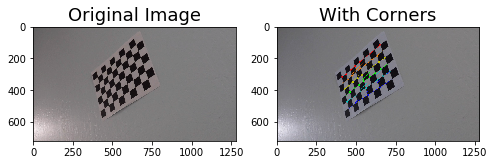

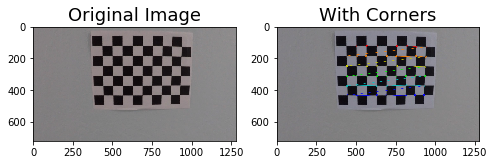

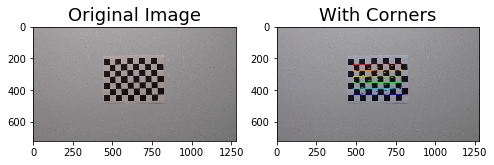

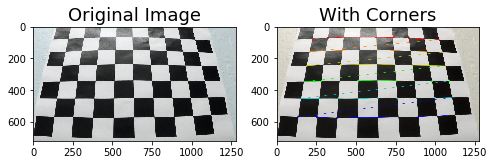

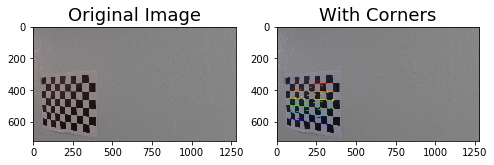

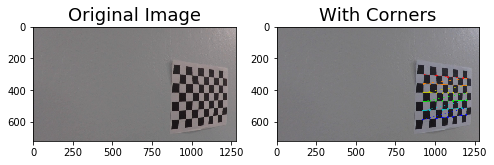

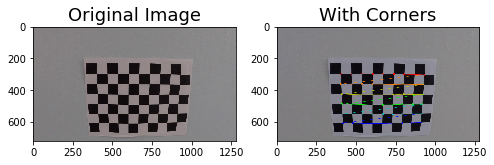

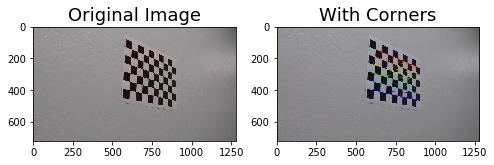

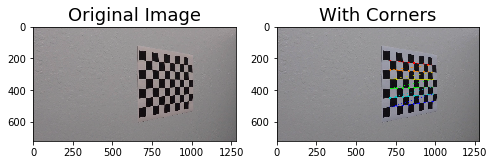

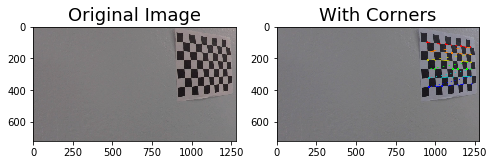

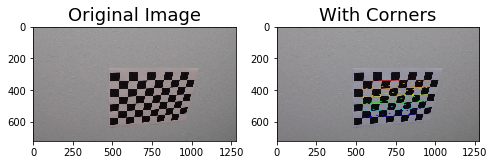

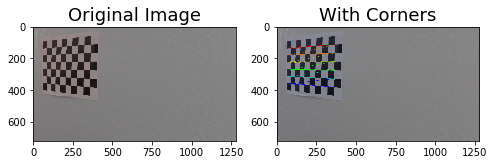

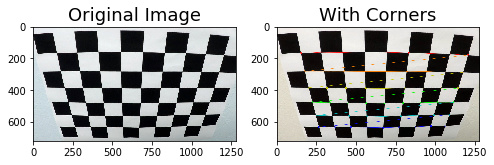

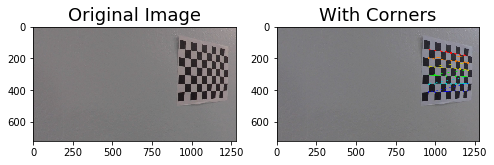

In [23]:
# prepare object points
nx = 9#TODO: enter the number of inside corners in x
ny = 6#TODO: enter the number of inside corners in y

objp =  np.zeros((6*9, 3), np.float32)
objp[:,:2] = np.mgrid[0:9, 0:6].T.reshape(-1,2)

objpoints = [] #3d points in the real world
imgpoints = [] #2d points in the image plane

images = glob.glob('camera_cal/calibration*.jpg')

for idx, fname in enumerate(images):
    
    # Make a list of calibration imageson images
    img = cv2.imread(fname)

    # Convert to grayscale
    gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)

    # Find the chessboard corners
    ret, corners = cv2.findChessboardCorners(gray, (nx, ny), None) #Only if it finds the corners


    # If found, draw corners and add object points and image points.
    if ret == True:
        # Draw and display the corners
        imgpoints.append(corners)
        objpoints.append(objp)
        
        cv2.drawChessboardCorners(img, (nx, ny), corners, ret)
        f, (ax1, ax2) = plt.subplots(1, 2, figsize=(8,4))
        ax1.imshow(cv2.cvtColor(mpimg.imread(fname), cv2.COLOR_BGR2RGB))
        ax1.set_title('Original Image', fontsize=18)
        
        ax2.imshow(cv2.cvtColor(img, cv2.COLOR_BGR2RGB))
        ax2.set_title('With Corners', fontsize=18)
        


Next with a function called *undistortion()* I will calculate the camera calibration matrix and distortion coefficients.

In [33]:
def undistortion(image, show=True, read=True):
    if read:
        img = cv2.imread(image)
        gray = cv2.cvtColor(img,cv2.COLOR_BGR2GRAY)
    
    
    img_size = (img.shape[1], img.shape[0])
    ret, mtx, dist, rvecs, tvecs = cv2.calibrateCamera(objpoints, imgpoints, gray.shape[::-1], None, None)
    dst = cv2.undistort(img, mtx, dist, None, mtx)
    
    if show:
        f, (ax1, ax2) = plt.subplots(1, 2, figsize=(9,6))
        ax1.imshow(cv2.cvtColor(img, cv2.COLOR_BGR2RGB))
        ax1.set_title('Original Image', fontsize=20)
        ax2.imshow(cv2.cvtColor(dst, cv2.COLOR_BGR2RGB))
        ax2.set_title('Undistorted Image', fontsize=20)
    else:
        return dst

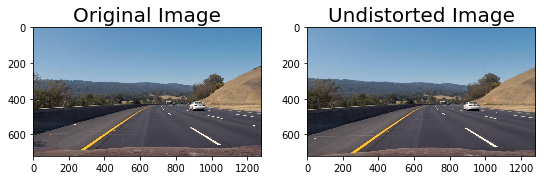

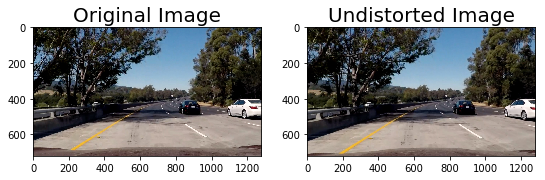

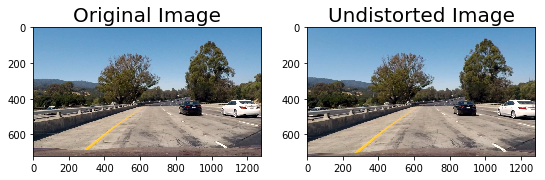

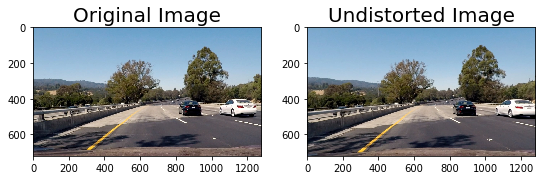

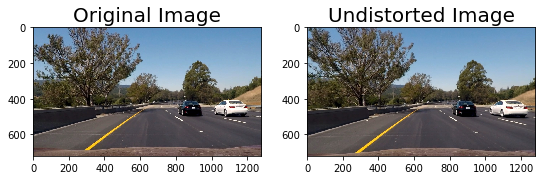

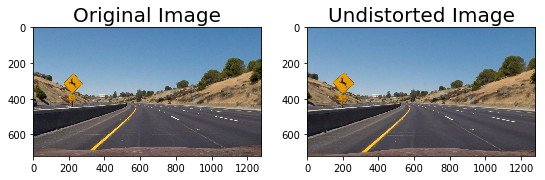

In [35]:
images = glob.glob('test_images/test*.jpg')
for image in images:
    undistortion(image)

## 2. Perspective Transform

I first undistort the images and now it is usefull to transform the image to a bird's eye view. It displays the lines in a way that they are parallel to eachother. 

In [38]:
def birds_eye(img, display=True, read=True):
    if read:
        undist = undistortion(img, show = False)
    else:
        undist = undistortion(img, show = False, read = False)
    img_size = (undist.shape[1], undist.shape[0])
    offset = 0
    src = np.float32([[490, 482],[810, 482],
                     [1250, 720],[40,720]])
    dst = np.float32([[0, 0], [1280, 0],
                     [1250, 720], [40, 720]])
    
    M = cv2.getPerspectiveTransform(src, dst)
    warped = cv2.warpPerspective(undist, M, img_size)
    
    if display:
        f, (ax1, ax2) = plt.subplots(1, 2, figsize=(9, 6))
        f.tight_layout()
        ax1.imshow(cv2.cvtColor(undist, cv2.COLOR_BGR2RGB))
        ax1.set_title('Undistorted Image', fontsize=20)
        ax2.imshow(cv2.cvtColor(warped, cv2.COLOR_BGR2RGB))
        ax2.set_title('Undistorted and Warped Image', fontsize=20)
        plt.subplots_adjust(left=0., right=1, top=0.9, bottom=0.)
    else:
        return warped, M

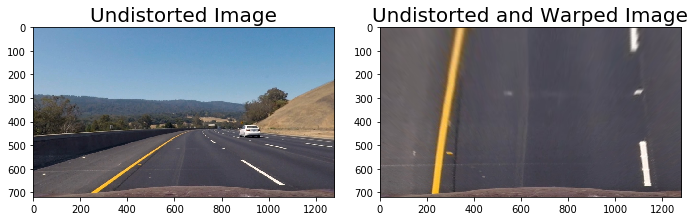

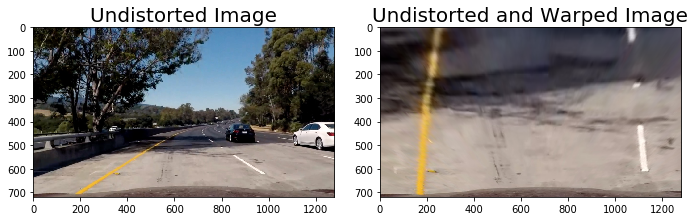

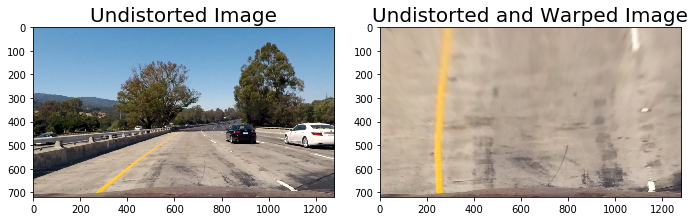

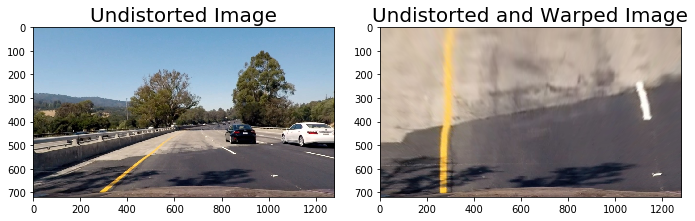

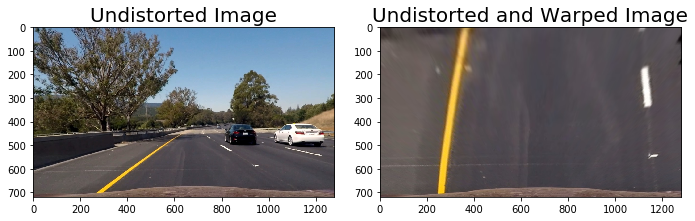

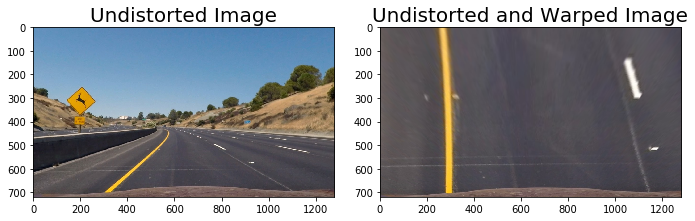

In [39]:
for image in glob.glob('test_images/test*.jpg'):
    birds_eye(image)

## 3. Binary Threshods

It is time to apply both, color and gradient thresholding. 

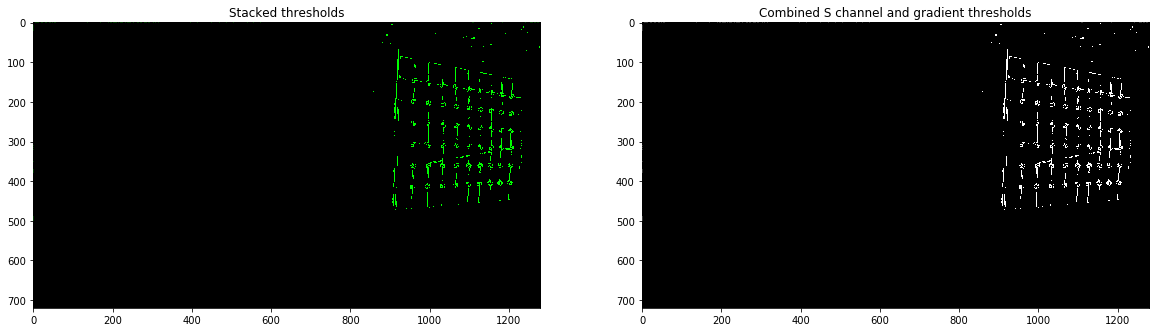

In [40]:
for image in glob.glob('test_images/test*.jpg'):
    birds_eye(image, display=False)
    
    hls = cv2.cvtColor(img, cv2.COLOR_RGB2HLS)
    s_channel = hls[:,:,2]

    gray = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)

    sobelx = cv2.Sobel(gray, cv2.CV_64F, 1, 0)
    abs_sobelx = np.absolute(sobelx)
    scaled_sobel = np.uint8(255*abs_sobelx/np.max(abs_sobelx)) #It divides by the max pixel value

    #Threshold x gradient
    thresh_min = 20
    thresh_max = 100
    sxbinary = np.zeros_like(scaled_sobel)
    sxbinary[(scaled_sobel >= thresh_min) & (scaled_sobel <= thresh_max)] = 1

    #Threshold color channel
    s_thresh_min = 170
    s_thresh_max = 255
    s_binary =  np.zeros_like(scaled_sobel)
    s_binary[(s_channel >= s_thresh_min) & (s_channel <= s_thresh_max)] = 1

    #Returns a stack of the two binary images.
    color_binary = np.dstack((np.zeros_like(sxbinary), sxbinary, s_binary)) * 255 #Stacks the sequence along the third axis to make a single array

    combined_binary = np.zeros_like(sxbinary) #Shame shape array but filled with zeroes
    combined_binary[(s_binary == 1) | (sxbinary == 1)] = 1

    #Plotting thresholded images
    f, (ax1, ax2) = plt.subplots(1, 2, figsize=(20,10))
    ax1.set_title('Stacked thresholds')
    ax1.imshow(color_binary)

    ax2.set_title('Combined S channel and gradient thresholds')
    ax2.imshow(combined_binary, cmap='gray')

        